In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-tweet-sentiment-analysis/bitcointweets.csv


In [2]:
# Load Data
df = pd.read_csv('../input/nlp-tweet-sentiment-analysis/bitcointweets.csv', header=None)
df = df[[1,7]]
df.columns = ['tweet','label']
df.head()

,tweet,label
0,"RT @ALXTOKEN: Paul Krugman, Nobel Luddite. I h...",['neutral']
1,@lopp @_Kevin_Pham @psycho_sage @naval But @Pr...,['neutral']
2,RT @tippereconomy: Another use case for #block...,['positive']
3,free coins https://t.co/DiuoePJdap,['positive']
4,RT @payvxofficial: WE are happy to announce th...,['positive']


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='label', ylabel='count'>

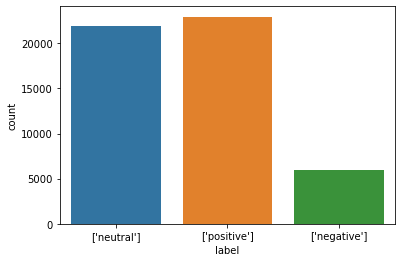

In [3]:
# inspect sentiment
sns.countplot(df['label'])

Majority of tweets are neutral and positive. Looks like there are not much negative tweets on Bitcoin! No wonder the price is skyrocketing!

In [4]:
# text length
df['text_length'] = df['tweet'].apply(len)
df[['label','text_length','tweet']].head()

,label,text_length,tweet
0,['neutral'],140,"RT @ALXTOKEN: Paul Krugman, Nobel Luddite. I h..."
1,['neutral'],137,@lopp @_Kevin_Pham @psycho_sage @naval But @Pr...
2,['positive'],140,RT @tippereconomy: Another use case for #block...
3,['positive'],34,free coins https://t.co/DiuoePJdap
4,['positive'],146,RT @payvxofficial: WE are happy to announce th...


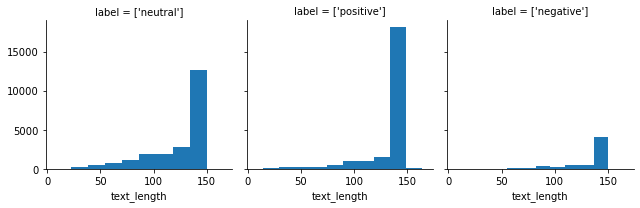

In [5]:
g = sns.FacetGrid(df,col='label')
g.map(plt.hist,'text_length')

As expected, most tweets are very short in length.

We are going to clean up the tweets, remove special chars, stop words, URL links, etc..

In [9]:

from nltk.corpus import stopwords
# from wordcloud import WordCloud
import re

def clean_text(s):
    s = re.sub(r'http\S+', '', s)
    s = re.sub('(RT|via)((?:\\b\\W*@\\w+)+)', ' ', s)
    s = re.sub(r'@\S+', '', s)
    s = re.sub('&amp', ' ', s)
    return s
df['clean_tweet'] = df['tweet'].apply(clean_text)

text = df['clean_tweet'].to_string().lower()

In [13]:

# wordcloud = WordCloud(
#     collocations=False,
#     relative_scaling=0.5,
#     stopwords=set(stopwords.words('english'))).generate(text)

# plt.figure(figsize=(12,12))
# plt.imshow(wordcloud)
# plt.axis("off")
# plt.show()

In [16]:
# Encode Categorical Variable
X = df['clean_tweet']
y = pd.get_dummies(df['label']).values
num_classes = df['label'].nunique()

In [17]:
seed = 101 # fix random seed for reproducibility
np.random.seed(seed)

In [18]:
# Split Train Test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=seed)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(40687,) (10172,) (40687, 3) (10172, 3)


In [19]:
# Tokenize Text
from keras.preprocessing.text import Tokenizer
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

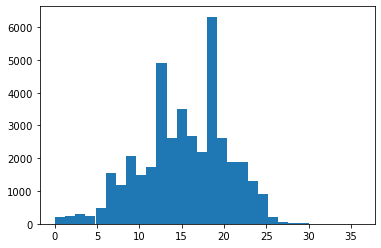

In [20]:
totalNumWords = [len(one_comment) for one_comment in X_train]
plt.hist(totalNumWords,bins = 30)
plt.show()

In [22]:
from keras.preprocessing import sequence
max_length = 30
X_train = sequence.pad_sequences(X_train, maxlen=max_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_length)
print(X_train.shape,X_test.shape)

(40687, 30) (10172, 30)


In [72]:

from keras.models import Sequential
from keras.layers import Dense,Embedding,Conv1D,MaxPooling1D,LSTM
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

batch_size = 128
epochs = 10

This deep learning model will have 2 CNN layers, 1 LSTM layer, and final dense layer for classification

In [75]:
max_features = 20000
embed_dim = 50

np.random.seed(seed)
K.clear_session()

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X_train.shape[1]))

model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
# model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=2))    
model.add(LSTM(50, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 50)            1000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 30, 32)            4832      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 15, 32)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 50)                16600     
_________________________________________________________________
dense (Dense)                (None, 3)                 153       
Total params: 1,021,585
Trainable params: 1,021,585
Non-trainable params: 0
_________________________________________________________________
None


In [76]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2, mode='min')

history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=epochs,
                    callbacks=early_stopping,
                    batch_size=batch_size, verbose=2)

Epoch 1/10
318/318 - 15s - loss: 0.3671 - accuracy: 0.8546 - val_loss: 0.1153 - val_accuracy: 0.9641
Epoch 2/10
318/318 - 11s - loss: 0.0598 - accuracy: 0.9828 - val_loss: 0.0816 - val_accuracy: 0.9757
Epoch 3/10
318/318 - 11s - loss: 0.0232 - accuracy: 0.9935 - val_loss: 0.1053 - val_accuracy: 0.9731
Epoch 4/10
318/318 - 11s - loss: 0.0130 - accuracy: 0.9967 - val_loss: 0.1033 - val_accuracy: 0.9769


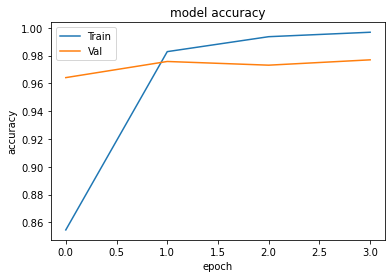

In [77]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

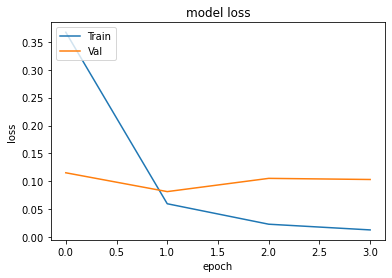

In [78]:
#Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc = 'upper left')
plt.show()

In [79]:
# predict class with test set
y_pred_test =  np.argmax(model.predict(X_test), axis=1)
print('Accuracy:\t{:0.1f}%'.format(accuracy_score(np.argmax(y_test,axis=1),y_pred_test)*100))
plt.tight_layout()

Accuracy:	97.7%


<Figure size 432x288 with 0 Axes>

In [80]:
#confusion matrix
confmat = confusion_matrix(np.argmax(y_test,axis=1), y_pred_test)
confmat

array([[1120,   53,   24],
       [  23, 4325,   40],
       [  26,   69, 4492]])

In [81]:
#classification report
print('\n')
print(classification_report(np.argmax(y_test,axis=1), y_pred_test))

    



              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1197
           1       0.97      0.99      0.98      4388
           2       0.99      0.98      0.98      4587

    accuracy                           0.98     10172
   macro avg       0.97      0.97      0.97     10172
weighted avg       0.98      0.98      0.98     10172



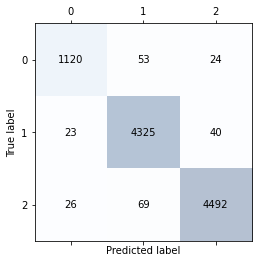

In [82]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    

Looks like we achieved very respectable accuracy (>97%), classifying most of the tweets in the test set correctly!